<a href="https://colab.research.google.com/github/mashalas/1govor/blob/main/Python_bootcamp_Day_2_%D0%A2%D0%93_%D0%B1%D0%BE%D1%82_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D1%84%D0%B0%D0%B9%D0%BB%D0%BE%D0%B2_%D0%B8_%D0%B4%D0%B5%D0%BF%D0%BB%D0%BE%D0%B9_%D0%BD%D0%B0_%D1%81%D0%B5%D1%80%D0%B2%D0%B5%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Дорабатываем Телеграм бота для обработки файлов

[Презентация](https://docs.google.com/presentation/d/154IKftEaOwI4k91YxwxX4HQduzYhb81Kz5GAI2slslc/edit?usp=sharing)

[Ссылка](https://colab.research.google.com/drive/1-CHjt_hCZAHHQMwmGeWtDRKkegmROgzP?usp=sharing) на заполненную рабочую тетрадь

[Ссылка](https://colab.research.google.com/drive/1zWV-CLjbiiKqL6c_GCzIx5opd8oiwVm3?usp=share_link) на новую рабочую тетрадь

## 1. Запустим первую версию бота



Скачиваем библиотеки

In [ ]:
!pip install pyTelegramBotAPI SpeechRecognition pydub

In [ ]:
import os
import telebot
import speech_recognition
from pydub import AudioSegment

Запускаем бота

Не забудьте **подставить свой токен** в блоке кода ниже

In [ ]:
# ↓↓↓ Ниже нужно вставить токен, который дал BotFather при регистрации
# Пример: token = '2007628239:AAEF4ZVqLiRKG7j49EC4vaRwXjJ6DN6xng8'
token = '<ваш токен>'  # <<< Ваш токен

bot = telebot.TeleBot(token)


def oga2wav(filename):
    # Конвертация формата файлов
    new_filename = filename.replace('.oga', '.wav')
    audio = AudioSegment.from_file(filename)
    audio.export(new_filename, format='wav')
    return new_filename


def recognize_speech(oga_filename):
    # Перевод голоса в текст + удаление использованных файлов
    wav_filename = oga2wav(oga_filename)
    recognizer = speech_recognition.Recognizer()

    with speech_recognition.WavFile(wav_filename) as source:
        wav_audio = recognizer.record(source)

    text = recognizer.recognize_google(wav_audio, language='ru')

    if os.path.exists(oga_filename):
        os.remove(oga_filename)

    if os.path.exists(wav_filename):
        os.remove(wav_filename)

    return text


def download_file(bot, file_id):
    # Скачивание файла, который прислал пользователь
    file_info = bot.get_file(file_id)
    downloaded_file = bot.download_file(file_info.file_path)
    filename = file_id + file_info.file_path
    filename = filename.replace('/', '_')
    with open(filename, 'wb') as f:
        f.write(downloaded_file)
    return filename


@bot.message_handler(commands=['start'])
def say_hi(message):
    # Функция, отправляющая "Привет" в ответ на команду /start
    bot.send_message(message.chat.id, 'Привет')


@bot.message_handler(content_types=['voice'])
def transcript(message):
    # Функция, отправляющая текст в ответ на голосовое
    filename = download_file(bot, message.voice.file_id)
    text = recognize_speech(filename)
    bot.send_message(message.chat.id, text)


# Запускаем бота. Он будет работать до тех пор, пока
# работает ячейка (крутится значок слева).
# Остановим ячейку - остановится бот
bot.polling()

## 2. Научим бота отправлять файлы пользователю

Первая версия - отправляем пользователю в ответ его же файл

Доступные типы файлов ([из документации](https://github.com/eternnoir/pyTelegramBotAPI#types)):



> text, audio, document, photo, sticker, video, video_note, voice, location, contact, new_chat_members, left_chat_member, new_chat_title, new_chat_photo, delete_chat_photo, group_chat_created, supergroup_chat_created, channel_chat_created, migrate_to_chat_id, migrate_from_chat_id, pinned_message, web_app_data



**Список** файлов, на которые будет реагировать бот, записываются через запятую в квадратных скобках.

Каждый элемент списка берется в кавычки.

Телеграм включает в сообщение 5 версий изображения. Максимальное качество - в последнем изображении в списке, поэтому для скачивания мы берем идентификатор из объекта `message.photo[-1]`

(индекс [-1] означает "первый с конца списка")

In [ ]:
bot = telebot.TeleBot(token)

def download_file(bot, file_id):
    # Функция загрузки файла, присланного пользователем
    file_info = bot.get_file(file_id)
    downloaded_file = bot.download_file(file_info.file_path)
    filename = file_id + file_info.file_path
    filename = filename.replace('/', '_')
    with open(filename, 'wb') as f:
        f.write(downloaded_file)
    return filename


# ↓↓↓ Пусть функция реагирует на изображения
@bot.message_handler(content_types=['photo'])
def resend_photo(message):
    # Скачиваем последний файл в списке с максимальным разрешением по file_id
    file_id = ...
    filename = download_file(bot, file_id)

    # Открываем изображение из файла с помощью функции open, 'rb' = read bytes
    image = ...

    # Отправляем изображение в чат с пользователем
    bot....(message.chat.id, image)

    # Не забываем закрыть файл
    image.close()


# Запускаем бота. Он будет работать до тех пор, пока
# работает ячейка (крутится значок слева).
# Остановим ячейку - остановится бот
bot.polling()

# 3. Напишем функцию для наложения фильтра на изображение

Потренируемся на тестовом изображении

In [ ]:
# Скачиваем картинку в рабочую папку

import urllib

url = "https://drive.google.com/uc?export=view&id=1clfJFsxixyYEWD4RpBrxOxf9lbE0YbdA"
filename = "test_image.png"
urllib.request.urlretrieve(url, filename)

Для обработки изображений воспользуемся библиотекой pillow ([документация](https://pillow.readthedocs.io/en/stable/index.html))

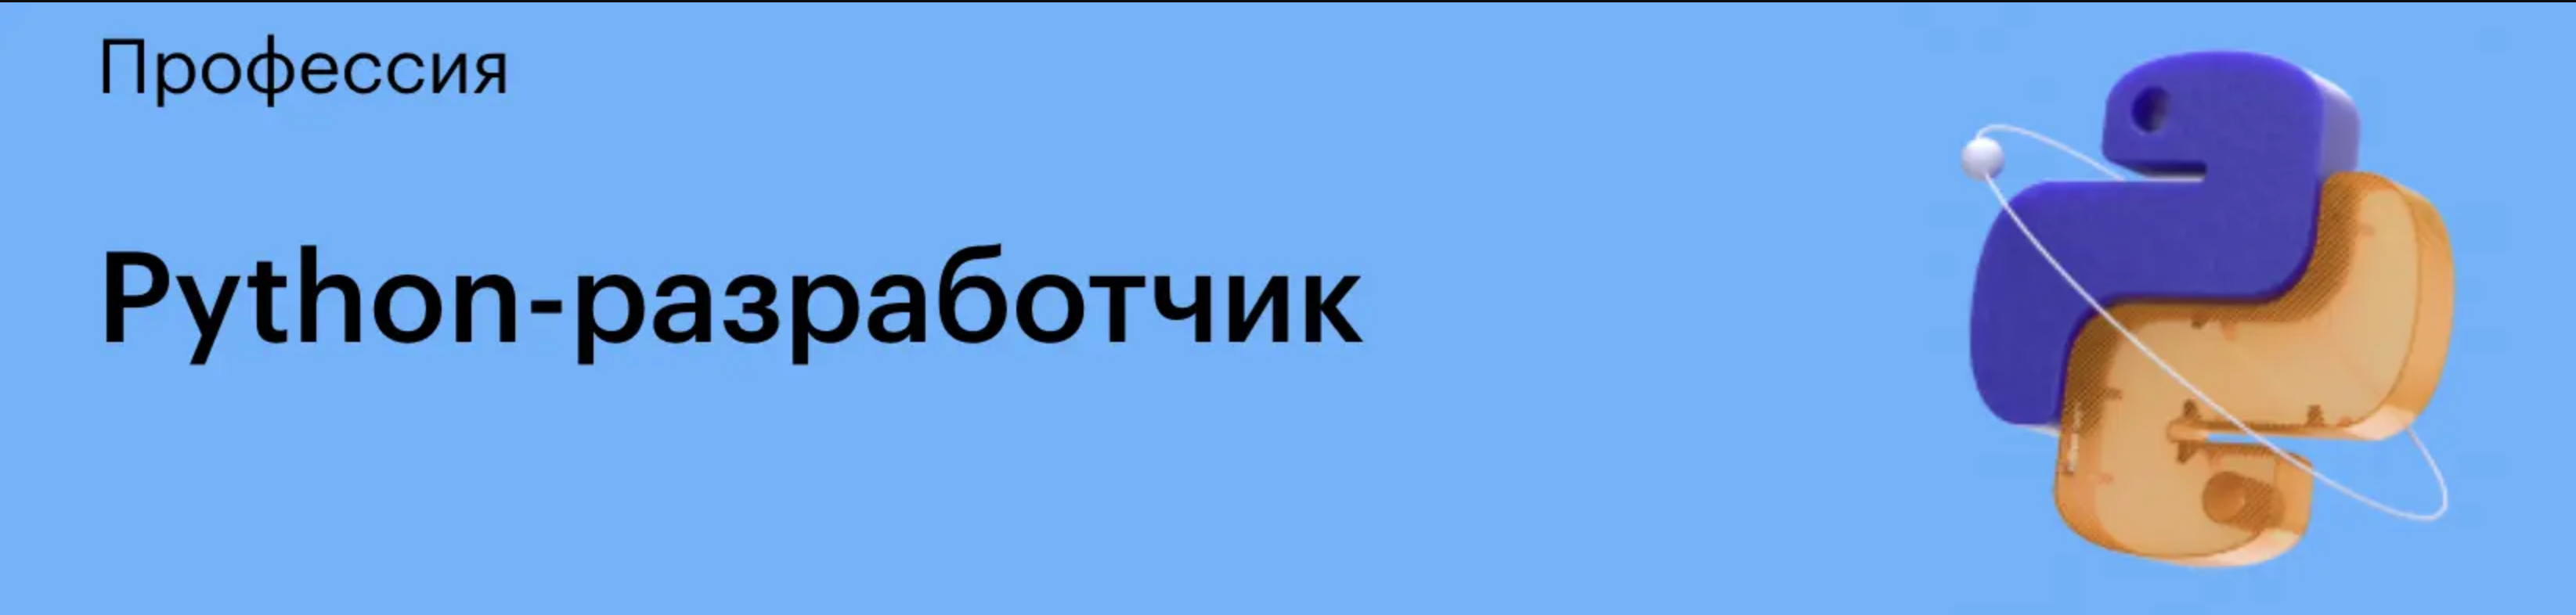

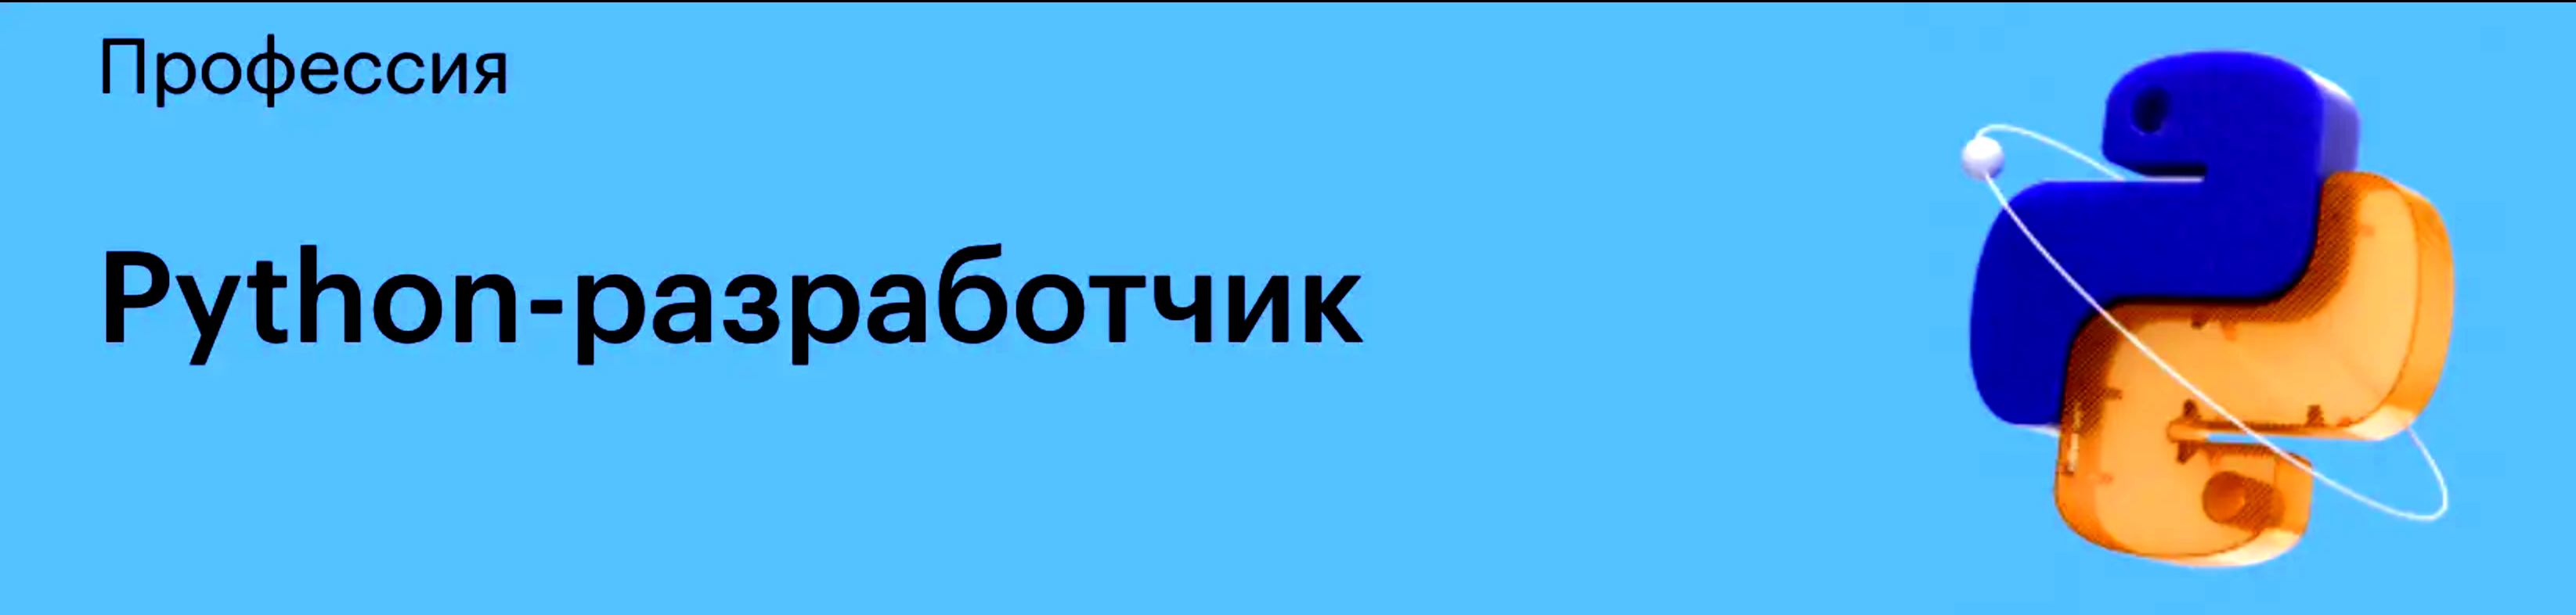

In [ ]:
from PIL import Image, ImageEnhance, ImageFilter

# Считаем изображение
source_image = Image.open('test_image.png')

# Нарисуем исходное изображение
source_image.show()

# Увеличим контрастность
enhanced_image = ImageEnhance.Contrast(source_image).enhance(1.8)

enhanced_image.show()

Доступные фильтры:
* BLUR
* CONTOUR
* DETAIL
* EDGE_ENHANCE
* EDGE_ENHANCE_MORE
* EMBOSS
* FIND_EDGES
* SHARPEN
* SMOOTH
* SMOOTH_MORE

In [ ]:
source_image = Image.open('test_image.png')

# Нарисуем исходное изображение
source_image.show()

# Упражнение: попробуйте различные фильтры:
enhanced_image = source_image.filter(ImageFilter.EMBOSS)
enhanced_image.show()

enhanced_image = source_image.filter(...)
enhanced_image.show()

Напишем функцию для преобразования изображения

In [ ]:
def transform_image(filename):
    # Считаем изображение с помощью Image.open
    source_image = Image.open(filename)

    # Наложим фильтр: ImageFilter.EMBOSS
    enhanced_image = source_image.filter(ImageFilter.EMBOSS)

    # Нужно конвертировать RGBA в RGB для сохранения в JPEG:
    enhanced_image = enhanced_image.convert('RGB')

    # Пересохраним изображение:
    enhanced_image.save(filename)

    return filename

# ИТОГ: Запускаем бота для перевода голоса в текст и обработки изображений

In [ ]:
!pip install pyTelegramBotAPI SpeechRecognition pydub

In [ ]:
import os
import telebot
import speech_recognition
from pydub import AudioSegment
from PIL import Image, ImageEnhance, ImageFilter


# ↓↓↓ Ниже нужно вставить токен, который дал BotFather при регистрации
# Пример: token = '2007628239:AAEF4ZVqLiRKG7j49EC4vaRwXjJ6DN6xng8'
token = '<ваш токен>'  # <<< Ваш токен

bot = telebot.TeleBot(token)


def transform_image(filename):
    # Функция обработки изображения
    source_image = Image.open(filename)
    enhanced_image = source_image.filter(ImageFilter.EMBOSS)
    enhanced_image = enhanced_image.convert('RGB')
    enhanced_image.save(filename)
    return filename


@bot.message_handler(content_types=['photo'])
def resend_photo(message):
    # Функция отправки обработанного изображения
    file_id = message.photo[-1].file_id
    filename = download_file(bot, file_id)

    # Трансформируем изображение
    transform_image(filename)

    image = open(filename, 'rb')
    bot.send_photo(message.chat.id, image)
    image.close()

    # Не забываем удалять ненужные изображения
    if os.path.exists(filename):
        os.remove(filename)


def oga2wav(filename):
    # Конвертация формата файлов
    new_filename = filename.replace('.oga', '.wav')
    audio = AudioSegment.from_file(filename)
    audio.export(new_filename, format='wav')
    return new_filename


def recognize_speech(oga_filename):
    # Перевод голоса в текст + удаление использованных файлов
    wav_filename = oga2wav(oga_filename)
    recognizer = speech_recognition.Recognizer()

    with speech_recognition.WavFile(wav_filename) as source:
        wav_audio = recognizer.record(source)

    text = recognizer.recognize_google(wav_audio, language='ru')

    if os.path.exists(oga_filename):
        os.remove(oga_filename)

    if os.path.exists(wav_filename):
        os.remove(wav_filename)

    return text


def download_file(bot, file_id):
    # Скачивание файла, который прислал пользователь
    file_info = bot.get_file(file_id)
    downloaded_file = bot.download_file(file_info.file_path)
    filename = file_id + file_info.file_path
    filename = filename.replace('/', '_')
    with open(filename, 'wb') as f:
        f.write(downloaded_file)
    return filename


@bot.message_handler(commands=['start'])
def say_hi(message):
    # Функция, отправляющая "Привет" в ответ на команду /start
    bot.send_message(message.chat.id, 'Привет')


@bot.message_handler(content_types=['voice'])
def transcript(message):
    # Функция, отправляющая текст в ответ на голосовое
    filename = download_file(bot, message.voice.file_id)
    text = recognize_speech(filename)
    bot.send_message(message.chat.id, text)


# Запускаем бота. Он будет работать до тех пор, пока работает ячейка (крутится значок слева).
# Остановим ячейку - остановится бот
bot.polling()

# Теперь запустим нашего бота на сервере, чтобы он мог работать круглосуточно
Переходим на https://www.pythonanywhere.com/

1. Регистрируемся на сайте
2. Создаем файл со скриптом бота:
    * В разделе **Files** нажимаем кнопку "**+ Open another file**" → вводим имя файла **tg_bot.py** → нажимаем кнопку "**Open**"
    * Копируем содержимое файла в последней ячейке с кодом
    * Возвращаемся на главную страницу
5. Создаем консоль, через которую запустим бота:
    * Под разделом Consoles есть раздел "New console", нажимаем кнопку "**$ Bash**"
    * В открывшейся консоли выполняем команду `pip install pyTelegramBotAPI SpeechRecognition pydub` (без восклицательного знака в начале строки)
    * Запускаем бота командой `python tg_bot.py`
    * Остановить бота можно комбинацией клавиш **Ctrl+C** (как при копировании)

# Домашнее задание
Улучшите своего бота, добавив функциональность сжатия изображения

Информация об изображении хранится в атрибуте `size`, который имеет тип tuple (кортеж).

С кортежами работают так же, как со списками: в квадратных скобках - индекс элемента. Нумерация начинается с 0.


In [ ]:
width = source_image.size[0]
height = source_image.size[1]

Арифметические операции в Python:
* `a + b` — плюс
* `a - b` — минус
* `a * b` — умножить
* `a / b` — поделить
* `a // b` — поделить нацело, отбросив остаток
* `a % b` — получить остаток от деления
* `round(a)` — округлить

Изменение разрешения производится через функцию .resize((ширина, высота)) - аргументом передается кортеж, который сам записывается в круглых скобках